# State evolution after MI
Interested in finding out how state evolves after MI, to see if they will end up in desirable cycling states

## Import packages

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
plt.style.use(["seaborn-dark"])
plt.rcParams["figure.figsize"] = (16, 9)
plt.rcParams["axes.labelsize"] = 20
plt.rcParams["axes.titlesize"] = 24
plt.rcParams["xtick.labelsize"] = 18
plt.rcParams["ytick.labelsize"] = 18
plt.rcParams["legend.fontsize"] = 20
plt.rcParams["font.family"] = 'serif'

import numpy as np

import centrex_TlF
from centrex_TlF import UncoupledBasisState
from state_prep.electric_fields import ElectricField, E_field_ring, E_field_tanh
from state_prep.hamiltonians import SlowHamiltonian
from state_prep.magnetic_fields import MagneticField
from state_prep.simulator import Simulator
from state_prep.trajectory import Trajectory
from state_prep.utils import vector_to_state

### Evolution of J=1 after MI

|J=1, mj = 1 > states go through E field ramping down from 30kV/cm

## Define molecule trajectory
Defining the molecule trajectory as a Trajectory object. Specifying the initial position as z = 50 mm, i.e. 50mm  after the center of the microwaves is, and on the axis of the beamline. Taking the beam velocity to be 200 m/s in the z-direction. The simulation ends when `zfin` is reached, 200 mm from the microwwaves.

In [2]:
trajectory = Trajectory(Rini = np.array((0,0,0)), Vini = np.array((0,0,184.)), zfin = 1000e-3)

## Define electric field
Defining an electric field that is an approximation of what the molecules should see in the real experiment.

In [3]:
trajectory = Trajectory(Rini = np.array((0,0,0)), Vini = np.array((0,0,184.)), zfin = 5e-3)

V1 = 30e3
z1 = 0
decayl = 5e-4
E_R = lambda R: E_field_tanh(R, z0 = z1, V = V1, l = decayl  )
electric_field = ElectricField(E_R)

At decayl = 1$\mu$m, states like J=2 will start to get populated, regardless of the magnetic field

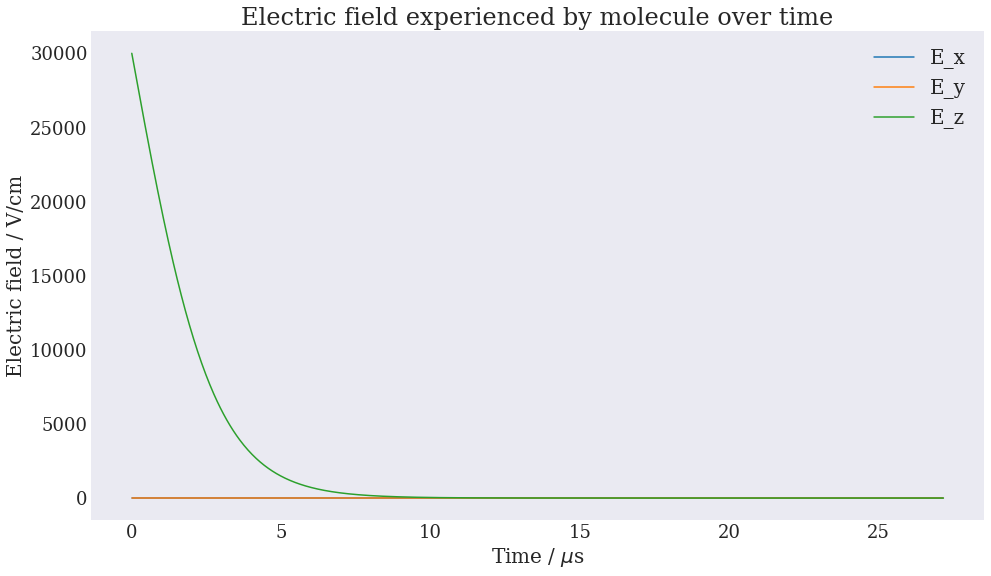

In [4]:
# Plot the electric field as a check:
electric_field.plot(trajectory)

## Define magnetic field
Define the magnetic field in Gauss. Using a constant field, either a nominal small field (so mF states become non-degenerate eigenstates of the Hamiltonian) or something resembilng Earth's magnetic field.

In [5]:
#B = np.array((0,0,1e-3))
B = np.array((0.2,0.45,0.1))
#B = np.array((0,0,1))
magnetic_field = MagneticField(lambda R: np.repeat(B.reshape(3,1),R.shape[1], axis = 1))

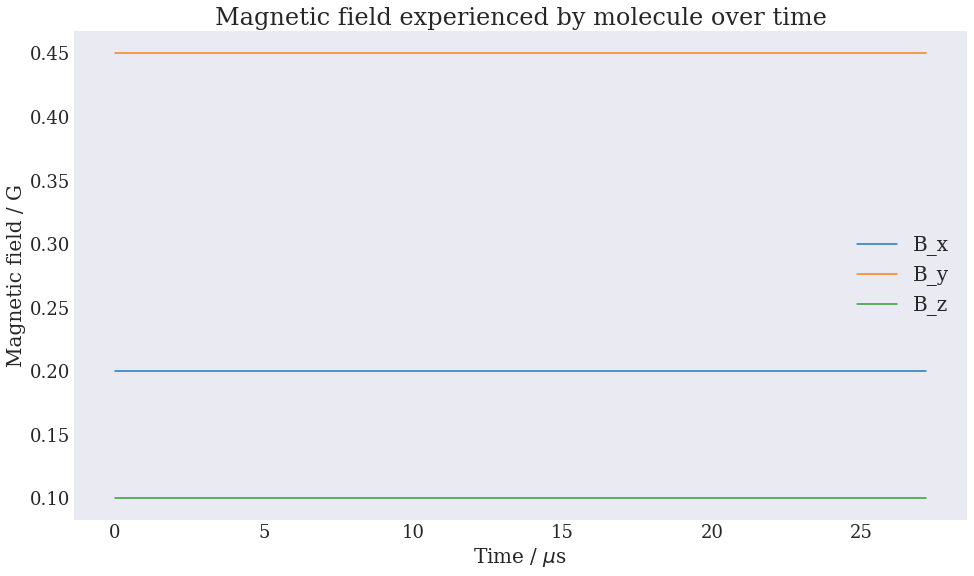

In [6]:
magnetic_field.plot(trajectory)

## Initial states
Define approximate initial states here.

In [7]:
#Define some useful approximate states

J1_up = (1*UncoupledBasisState(J = 1, mJ = 1, I1 = 1/2, m1 = 1/2, I2 = 1/2, m2 = 1/2, P = -1, Omega = 0, electronic_state='X'))

J1_down = (1*UncoupledBasisState(J = 1, mJ = 1, I1 = 1/2, m1 = -1/2, I2 = 1/2, m2 = 1/2, P = -1, Omega = 0, electronic_state='X'))

initial_states_approx = [J1_up, J1_down]

## Define slowly varying Hamiltonian
Define a Hamiltonian object that represents the slowly varying part of the Hamiltonian (i.e. everything except the microwaves). Using J = 0-3 here since we're interested in the time-evolution of J = 2 states; J = 1 and 3 are absolutely required since the electric field couples J = 2 to these, J = 0 is not strictly necessary. Since the Stark energies are << the rotational energies, we mostly just need the J of interest $\pm 1$.

In [8]:
Js = [0,1,2,3]
hamiltonian = SlowHamiltonian(Js,trajectory, electric_field, magnetic_field)

## Time-evolution
Next define a Simulator and use it to numerically integrate the Schroedinger equation to see how the states evolve as the electric field is ramped down. 

In [9]:
simulator = Simulator(trajectory, electric_field, magnetic_field, initial_states_approx, hamiltonian)

In [10]:
result = simulator.run()

100%|████████████████████████████████████████████████████████████████████████████| 9999/9999 [00:08<00:00, 1236.54it/s]


## Plot results

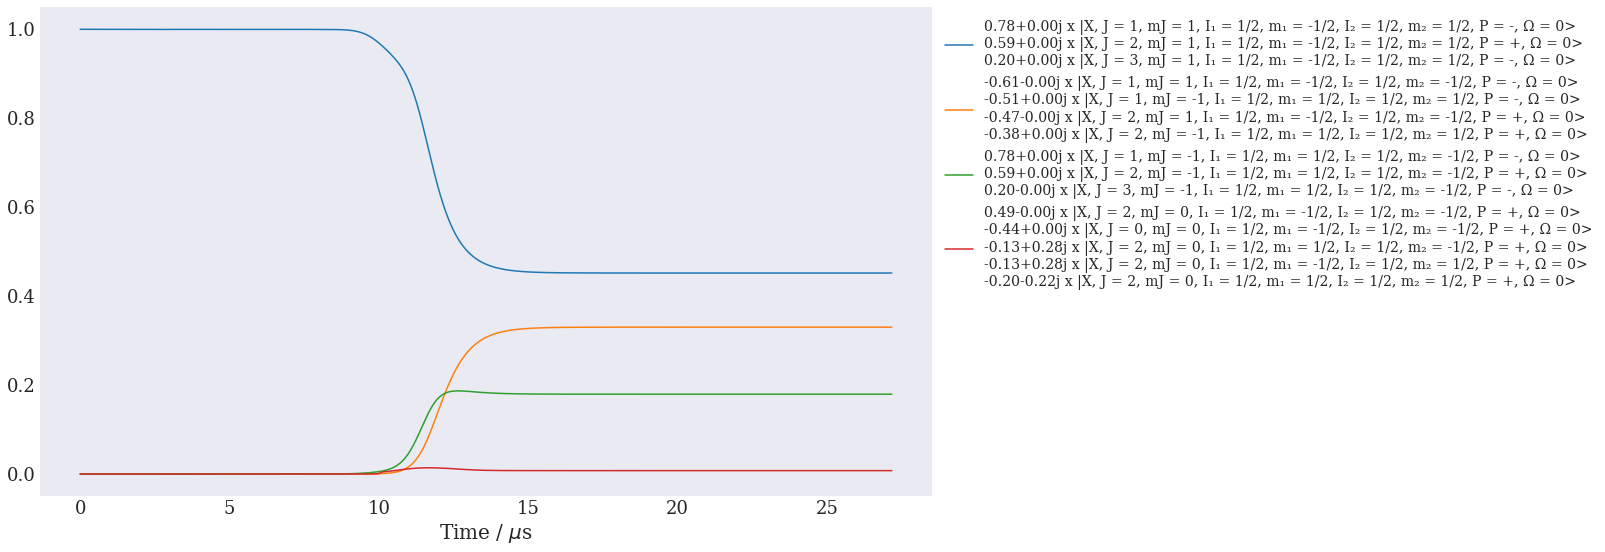

In [14]:
initial_state = result.initial_states[1]
large_prob_states = result.find_large_prob_states(initial_state, N=4)
fig, ax = plt.subplots()
result.plot_state_probabilities(large_prob_states, initial_state, ax = ax, tolerance = 0.2)
ax.legend(fontsize = 14, bbox_to_anchor = (1,1))

In [17]:

QN = result.hamiltonian.QN
final_state_vec_J1_up = result.psis[-1,1,:]
final_state_J1_up = (vector_to_state(final_state_vec_J1_up, QN)
                       .order_by_amp())
print("|J = 1, mJ = 1, m1 = 1/2, m2 = 1/2 > ->")
final_state_J1_up.print_state(probabilities = True)

|J = 1, mJ = 1, m1 = 1/2, m2 = 1/2 > ->
+0.6254+0.0000j x |X, J = 1, mJ = 1, I₁ = 1/2, m₁ = -1/2, I₂ = 1/2, m₂ = 1/2, P = -, Ω = 0>
+0.3625+0.0000j x |X, J = 1, mJ = 0, I₁ = 1/2, m₁ = 1/2, I₂ = 1/2, m₂ = 1/2, P = -, Ω = 0>


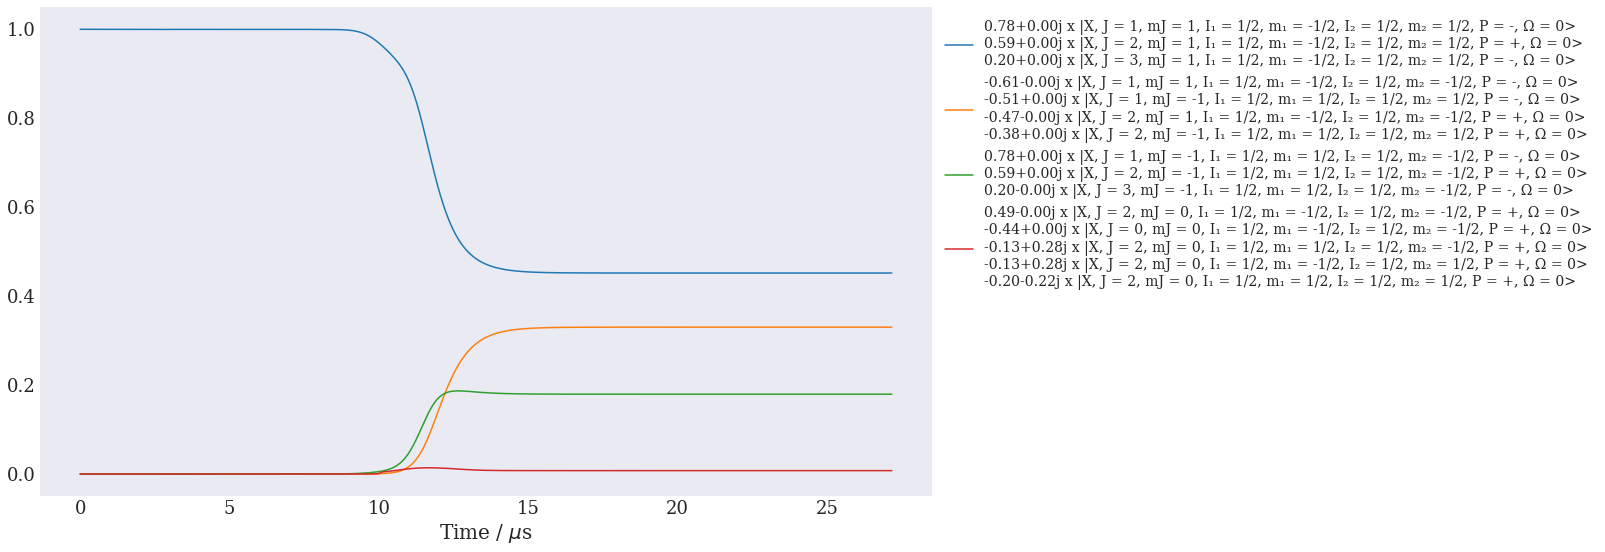

In [53]:
initial_state = result.initial_states[1]
large_prob_states = result.find_large_prob_states(initial_state, N=4)
fig, ax = plt.subplots()
result.plot_state_probabilities(large_prob_states, initial_state, ax = ax, tolerance = 0.2)
ax.legend(fontsize = 14, bbox_to_anchor = (1,1))

## Convert final state vectors to coupled basis

In [54]:
QN = result.hamiltonian.QN

# Starting in singlet
final_state_vec_J1_up = result.psis[-1,0,:]
final_state_J1_up = (vector_to_state(final_state_vec_J1_up, QN).transform_to_coupled()
                       .order_by_amp())
print("|J = 1, mJ = 1, m1 = 1/2, m2 = 1/2 > ->")
final_state_J1_up.print_state(probabilities = True)


final_state_vec_J1_down = result.psis[-1,1,:]
final_state_J1_down = (vector_to_state(final_state_vec_J1_down, QN).remove_small_components().transform_to_coupled()
                         .order_by_amp())
print("\n|J = 1, mJ = 1, m1 = -1/2, m2 = 1/2 >  ->")
final_state_J1_down.print_state(probabilities = True)


|J = 1, mJ = 1, m1 = 1/2, m2 = 1/2 > ->
+0.9877+0.0000j x |X, J = 1, F₁ = 3/2, F = 2, mF = 2, I₁ = 1/2, I₂ = 1/2, P = -, Ω = 0>

|J = 1, mJ = 1, m1 = -1/2, m2 = 1/2 >  ->
+0.9661+0.0000j x |X, J = 1, F₁ = 1/2, F = 1, mF = 1, I₁ = 1/2, I₂ = 1/2, P = -, Ω = 0>
+0.0243+0.0000j x |X, J = 1, F₁ = 3/2, F = 2, mF = 1, I₁ = 1/2, I₂ = 1/2, P = -, Ω = 0>


At decay length around 0.5mm, states start crossing into different F1 and F states, which would be problematic for state transfer.

### for a reasonable decay:

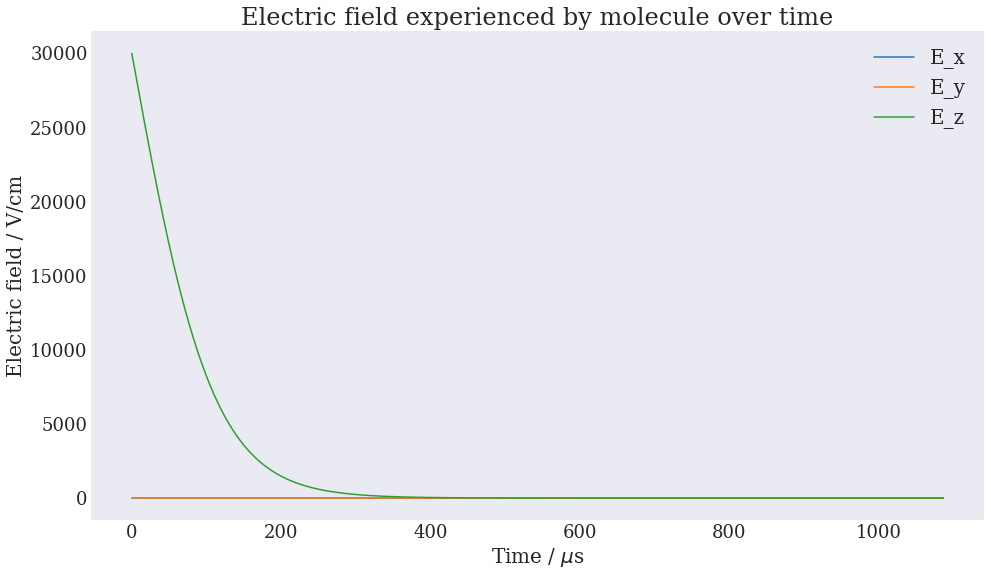

In [14]:
trajectory = Trajectory(Rini = np.array((0,0,0)), Vini = np.array((0,0,184.)), zfin = 2e-1)

V1 = 30e3
z1 = 0
decayl = 2e-2
E_R = lambda R: E_field_tanh(R, z0 = z1, V = V1, l = decayl  )
electric_field = ElectricField(E_R)

# Plot the electric field as a check:
electric_field.plot(trajectory)

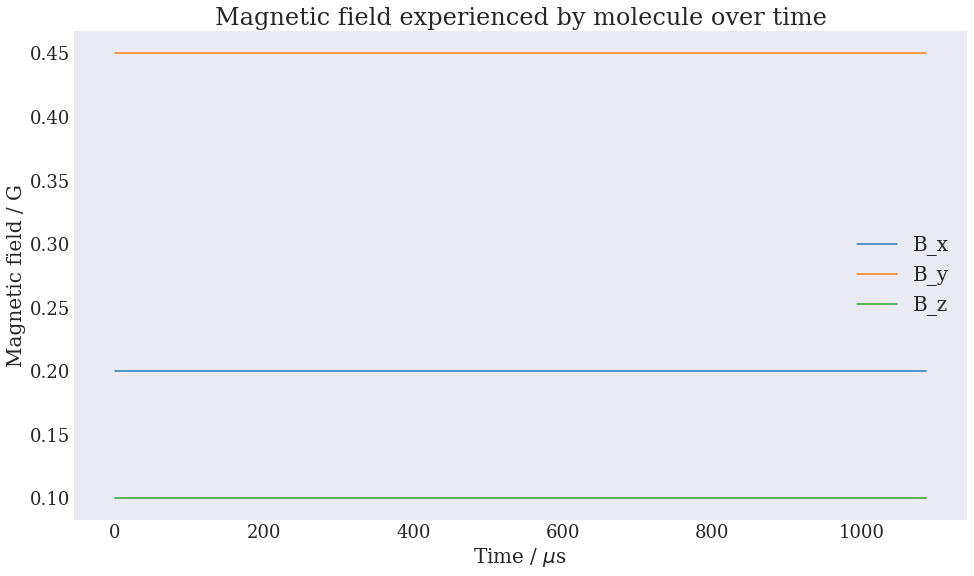

In [15]:
#B = np.array((0,0,1e-3))
B = np.array((0.2,0.45,0.1))
#B = np.array((0,0,1))
magnetic_field = MagneticField(lambda R: np.repeat(B.reshape(3,1),R.shape[1], axis = 1))

magnetic_field.plot(trajectory)

In [16]:
#Define some useful approximate states

J1_up = (1*UncoupledBasisState(J = 1, mJ = 1, I1 = 1/2, m1 = 1/2, I2 = 1/2, m2 = 1/2, P = -1, Omega = 0, electronic_state='X'))

J1_down = (1*UncoupledBasisState(J = 1, mJ = 1, I1 = 1/2, m1 = -1/2, I2 = 1/2, m2 = 1/2, P = -1, Omega = 0, electronic_state='X'))

initial_states_approx = [J1_up, J1_down]

In [17]:
simulator = Simulator(trajectory, electric_field, magnetic_field, initial_states_approx, hamiltonian)
result = simulator.run()

100%|████████████████████████████████████████████████████████████████████████████| 9999/9999 [00:09<00:00, 1035.81it/s]


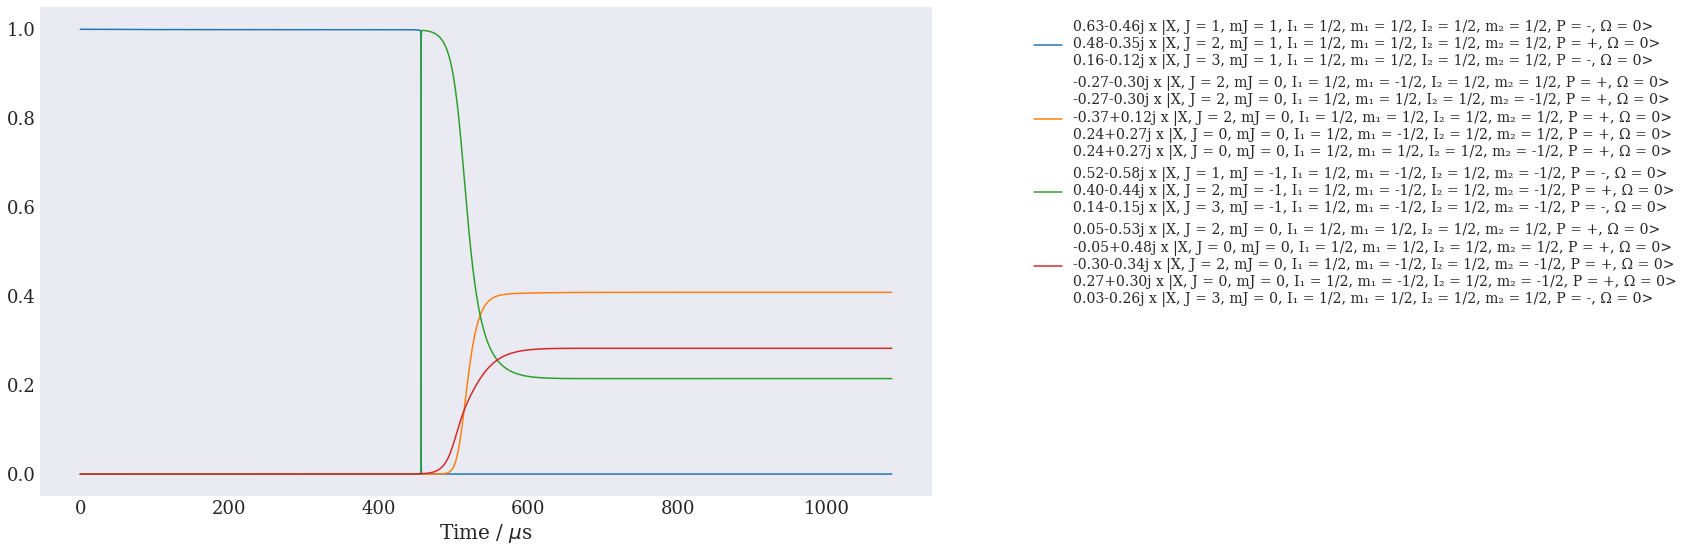

In [18]:
initial_state = result.initial_states[0]
large_prob_states = result.find_large_prob_states(initial_state, N=4)
fig, ax = plt.subplots()
result.plot_state_probabilities(large_prob_states, initial_state, ax = ax, tolerance = 0.2)
ax.legend(fontsize = 14, bbox_to_anchor = (1.1,1))

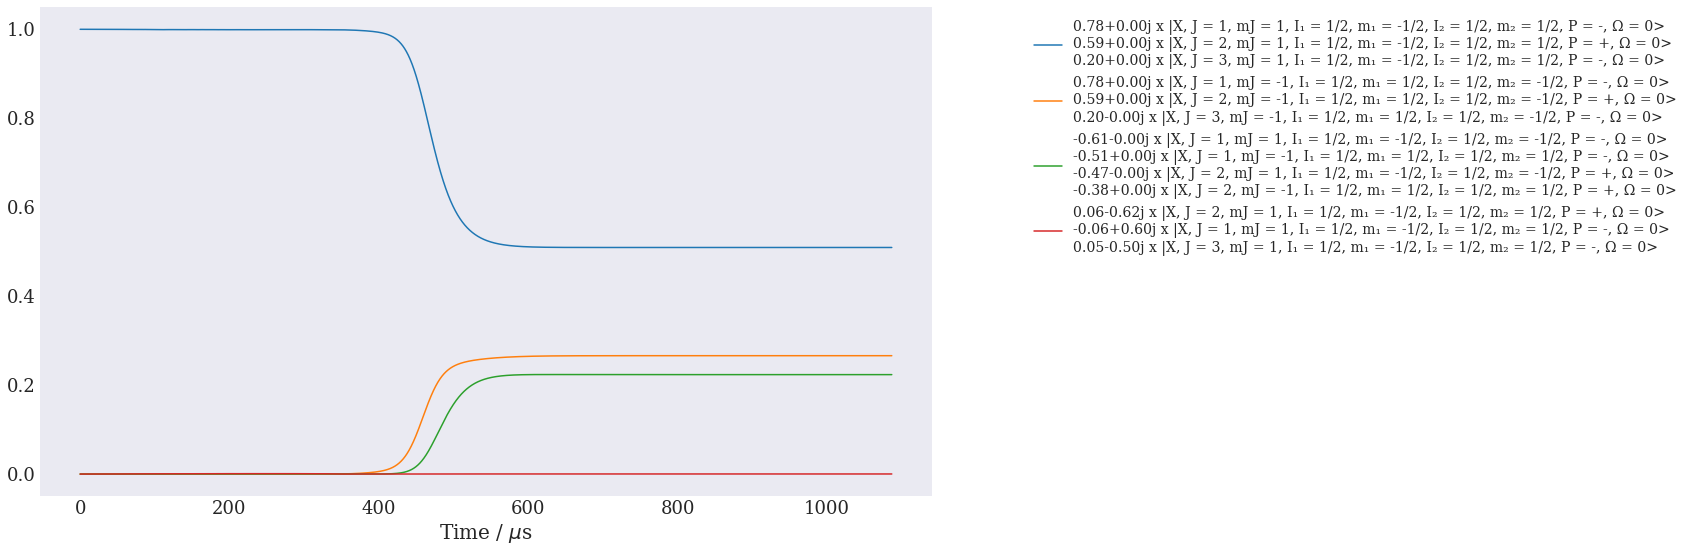

In [19]:
initial_state = result.initial_states[1]
large_prob_states = result.find_large_prob_states(initial_state, N=4)
fig, ax = plt.subplots()
result.plot_state_probabilities(large_prob_states, initial_state, ax = ax, tolerance = 0.2)
ax.legend(fontsize = 14, bbox_to_anchor = (1.1,1))

In [55]:
QN = result.hamiltonian.QN

# Starting in singlet
final_state_vec_J1_up = result.psis[-1,0,:]
final_state_J1_up = (vector_to_state(final_state_vec_J1_up, QN).remove_small_components().transform_to_coupled()
                       .order_by_amp())
print("|J = 1, mJ = 1, m1 = 1/2, m2 = 1/2 > ->")
final_state_J1_up.make_real().print_state()


final_state_vec_J1_down = result.psis[-1,1,:]
final_state_J1_down = (vector_to_state(final_state_vec_J1_down, QN).remove_small_components().transform_to_coupled()
                         .order_by_amp())
print("\n|J = 1, mJ = 1, m1 = -1/2, m2 = 1/2 >  ->")
final_state_J1_down.make_real().print_state()


|J = 1, mJ = 1, m1 = 1/2, m2 = 1/2 > ->
+0.9407-0.3205j x |X, J = 1, F₁ = 3/2, F = 2, mF = 2, I₁ = 1/2, I₂ = 1/2, P = -, Ω = 0>

|J = 1, mJ = 1, m1 = -1/2, m2 = 1/2 >  ->
+0.1836-0.9656j x |X, J = 1, F₁ = 1/2, F = 1, mF = 1, I₁ = 1/2, I₂ = 1/2, P = -, Ω = 0>
-0.1548+0.0168j x |X, J = 1, F₁ = 3/2, F = 2, mF = 1, I₁ = 1/2, I₂ = 1/2, P = -, Ω = 0>


### different mF states still gets populated, because as E field goes to 0, B field dominates, need to provide a E field as a quantization axis

### How does the decay look like near 0?

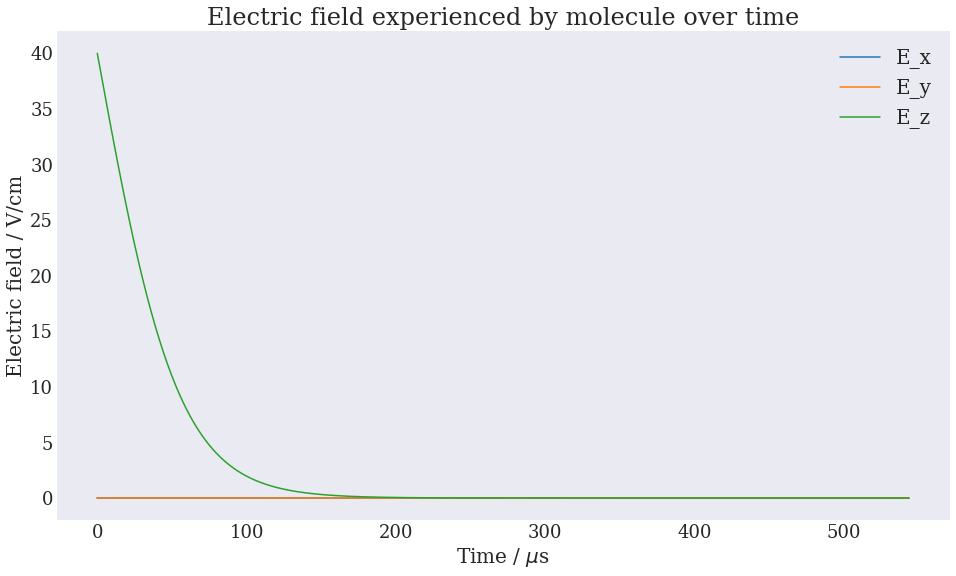

In [99]:
trajectory = Trajectory(Rini = np.array((0,0,0)), Vini = np.array((0,0,184.)), zfin = 1e-1)

V1 = 40
z1 = 0
decayl = 1e-2
E_R = lambda R: E_field_tanh(R, z0 = z1, V = V1, l = decayl  )
electric_field = ElectricField(E_R)

# Plot the electric field as a check:
electric_field.plot(trajectory)

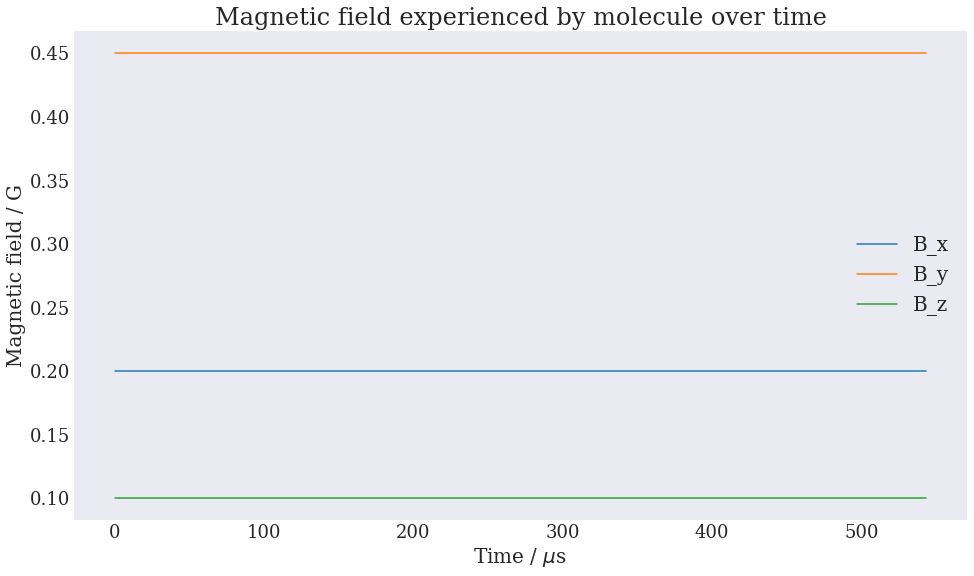

In [100]:
#B = np.array((0,0,1e-3))
B = np.array((0.2,0.45,0.1))
#B = np.array((0,0,1))
magnetic_field = MagneticField(lambda R: np.repeat(B.reshape(3,1),R.shape[1], axis = 1))

magnetic_field.plot(trajectory)

In [101]:
#Define some useful approximate states

J1_up = (1*UncoupledBasisState(J = 1, mJ = 1, I1 = 1/2, m1 = 1/2, I2 = 1/2, m2 = 1/2, P = -1, Omega = 0, electronic_state='X'))

J1_down = (1*UncoupledBasisState(J = 1, mJ = 1, I1 = 1/2, m1 = -1/2, I2 = 1/2, m2 = 1/2, P = -1, Omega = 0, electronic_state='X'))

initial_states_approx = [J1_up, J1_down]

In [102]:
simulator = Simulator(trajectory, electric_field, magnetic_field, initial_states_approx, hamiltonian)
result = simulator.run()

100%|████████████████████████████████████████████████████████████████████████████| 9999/9999 [00:06<00:00, 1437.25it/s]


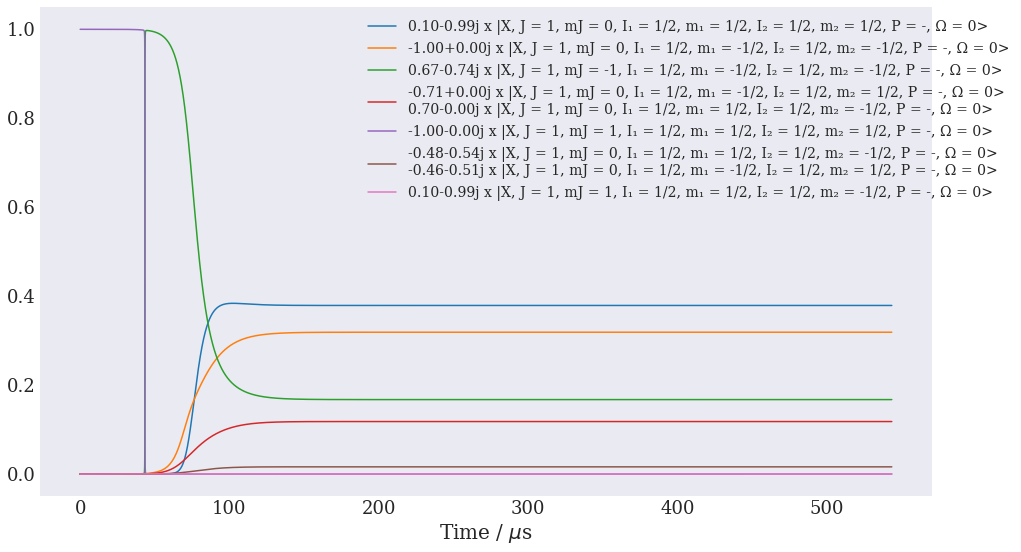

In [103]:
initial_state = result.initial_states[0]
large_prob_states = result.find_large_prob_states(initial_state, N=7)
fig, ax = plt.subplots()
result.plot_state_probabilities(large_prob_states, initial_state, ax = ax, tolerance = 0.5)
ax.legend(fontsize = 14, bbox_to_anchor = (1.1,1))

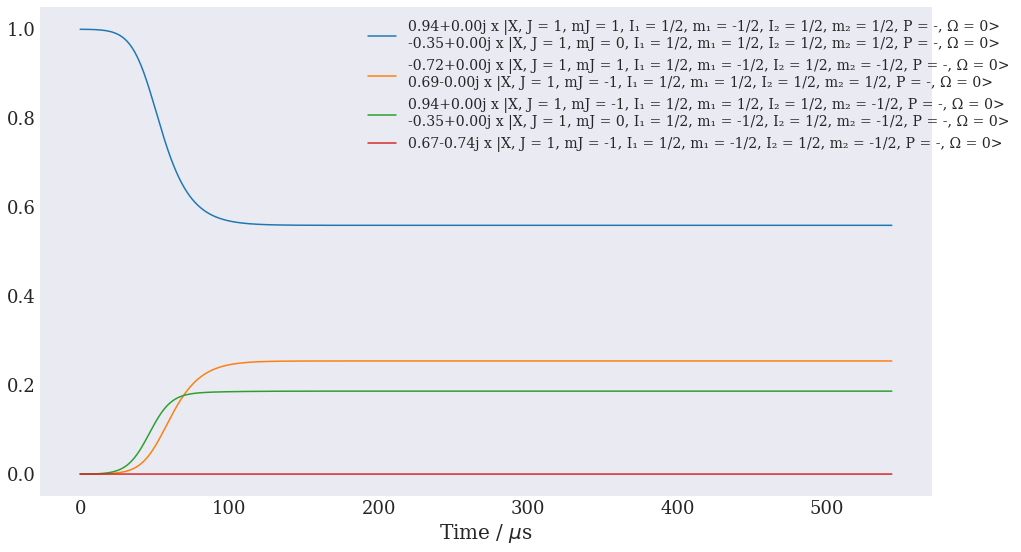

In [104]:
initial_state = result.initial_states[1]
large_prob_states = result.find_large_prob_states(initial_state, N=4)
fig, ax = plt.subplots()
result.plot_state_probabilities(large_prob_states, initial_state, ax = ax, tolerance = 0.2)
ax.legend(fontsize = 14, bbox_to_anchor = (1.1,1))

In [105]:
QN = result.hamiltonian.QN

# Starting in singlet
final_state_vec_J1_up = result.psis[-1,0,:]
final_state_J1_up = (vector_to_state(final_state_vec_J1_up, QN).remove_small_components().transform_to_coupled()
                       .order_by_amp())
print("|J = 1, mJ = 1, m1 = 1/2, m2 = 1/2 > ->")
final_state_J1_up.make_real().print_state()


final_state_vec_J1_down = result.psis[-1,1,:]
final_state_J1_down = (vector_to_state(final_state_vec_J1_down, QN).remove_small_components().transform_to_coupled()
                         .order_by_amp())
print("\n|J = 1, mJ = 1, m1 = -1/2, m2 = 1/2 >  ->")
final_state_J1_down.make_real().print_state()



|J = 1, mJ = 1, m1 = 1/2, m2 = 1/2 > ->
+0.7426+0.0000j x |X, J = 1, F₁ = 3/2, F = 2, mF = -2, I₁ = 1/2, I₂ = 1/2, P = -, Ω = 0>
-0.2562-0.5508j x |X, J = 1, F₁ = 3/2, F = 2, mF = -1, I₁ = 1/2, I₂ = 1/2, P = -, Ω = 0>
-0.1669+0.2122j x |X, J = 1, F₁ = 3/2, F = 2, mF = 0, I₁ = 1/2, I₂ = 1/2, P = -, Ω = 0>

|J = 1, mJ = 1, m1 = -1/2, m2 = 1/2 >  ->
-0.9328+0.0000j x |X, J = 1, F₁ = 1/2, F = 1, mF = -1, I₁ = 1/2, I₂ = 1/2, P = -, Ω = 0>
+0.1429+0.3019j x |X, J = 1, F₁ = 1/2, F = 1, mF = 0, I₁ = 1/2, I₂ = 1/2, P = -, Ω = 0>


When earth's magnetic field is present, at about 20V/cm different mf states start to get populated.

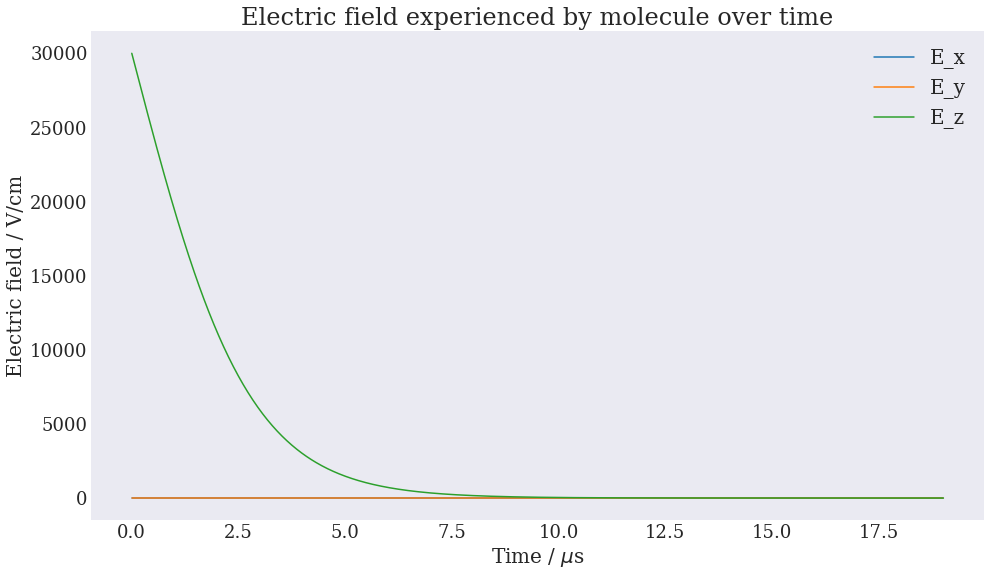

In [85]:
V1 = 30e3
z1 = 0
decayl = 0.5e-3

trajectory = Trajectory(Rini = np.array((0,0,0)), Vini = np.array((0,0,184.)), zfin = decayl *7)
E_R = lambda R: E_field_tanh(R, z0 = z1, V = V1, l = decayl  )
electric_field = ElectricField(E_R)

# Plot the electric field as a check:
electric_field.plot(trajectory)

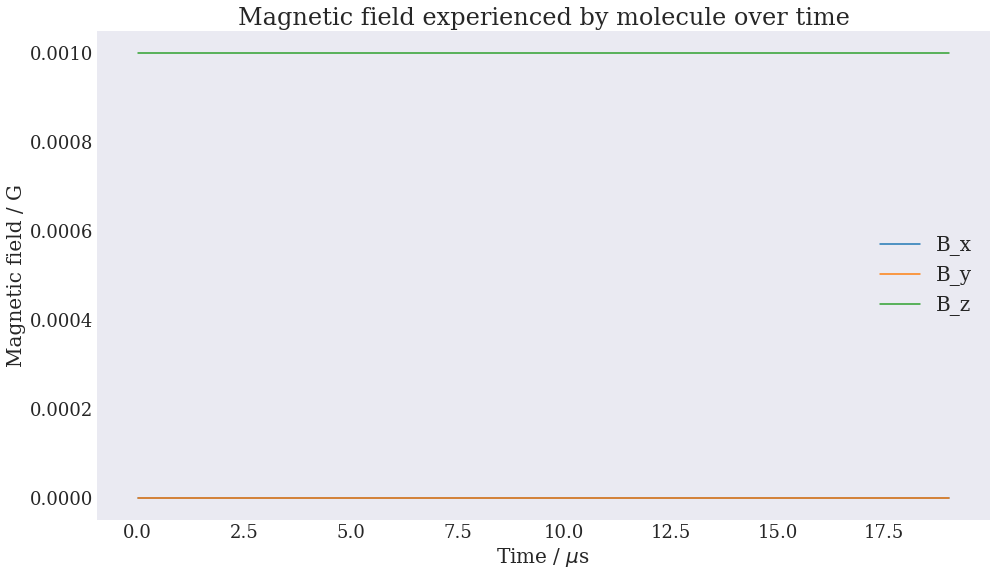

In [86]:
B = np.array((0,0,1e-3))
#B = np.array((0.2,0.45,0.1))
#B = np.array((0,0,1))
magnetic_field = MagneticField(lambda R: np.repeat(B.reshape(3,1),R.shape[1], axis = 1))

magnetic_field.plot(trajectory)

In [87]:
#Define some useful approximate states

J1_up = (1*UncoupledBasisState(J = 1, mJ = 1, I1 = 1/2, m1 = 1/2, I2 = 1/2, m2 = 1/2, P = -1, Omega = 0, electronic_state='X'))

J1_down = (1*UncoupledBasisState(J = 1, mJ = 1, I1 = 1/2, m1 = -1/2, I2 = 1/2, m2 = 1/2, P = -1, Omega = 0, electronic_state='X'))

initial_states_approx = [J1_up, J1_down]

In [88]:
simulator = Simulator(trajectory, electric_field, magnetic_field, initial_states_approx, hamiltonian)
result = simulator.run()

100%|█████████████████████████████████████████████████████████████████████████████| 9999/9999 [00:10<00:00, 962.17it/s]


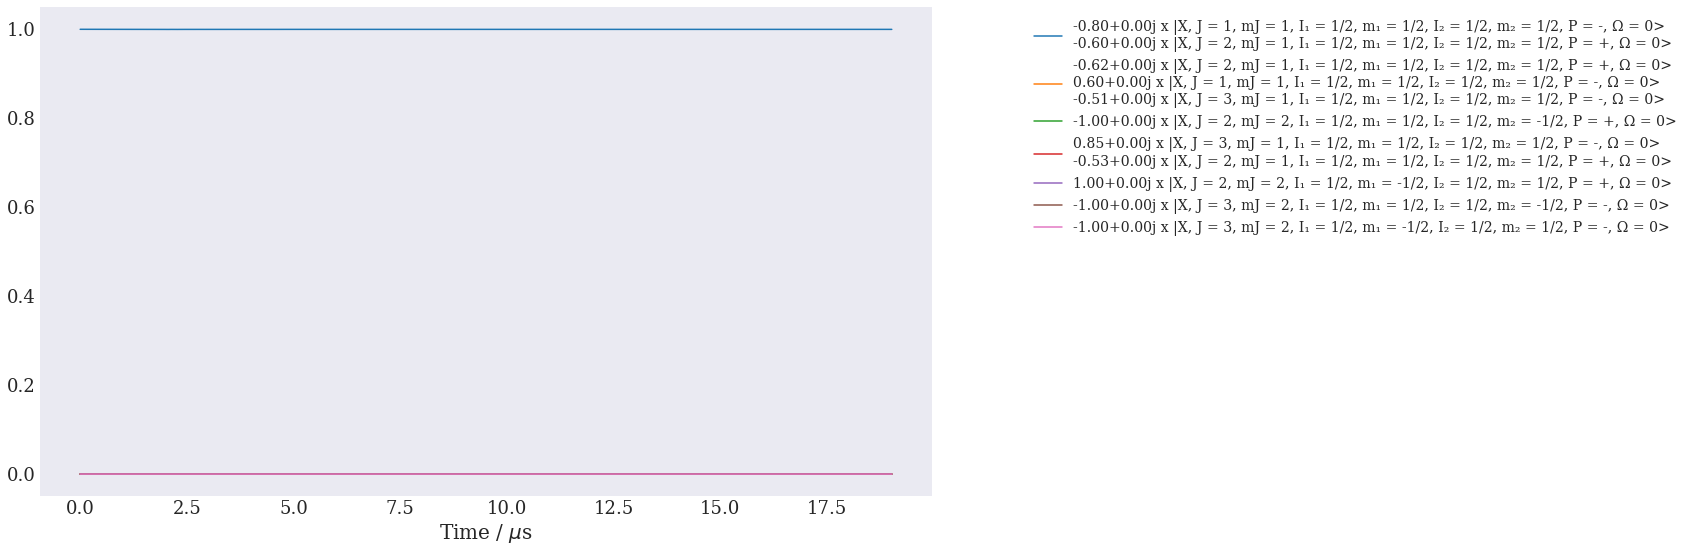

In [89]:
initial_state = result.initial_states[0]
large_prob_states = result.find_large_prob_states(initial_state, N=7)
fig, ax = plt.subplots()
result.plot_state_probabilities(large_prob_states, initial_state, ax = ax, tolerance = 0.5)
ax.legend(fontsize = 14, bbox_to_anchor = (1.1,1))

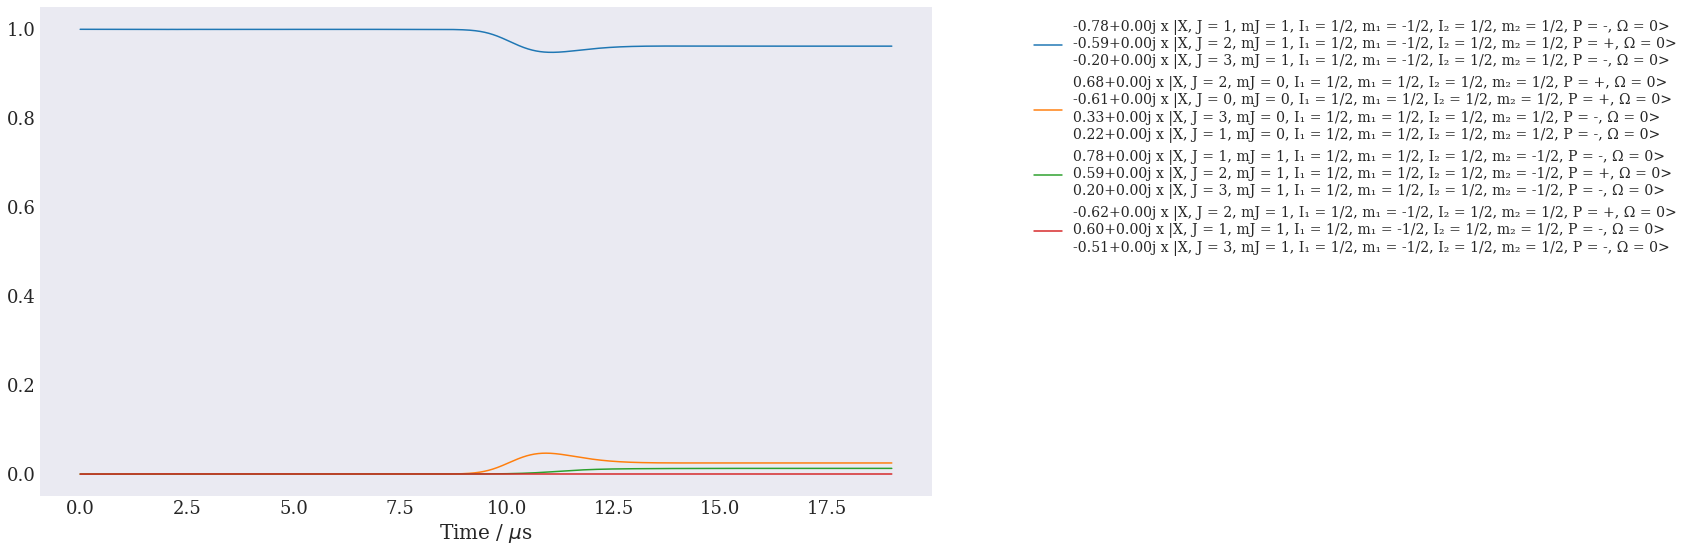

In [90]:
initial_state = result.initial_states[1]
large_prob_states = result.find_large_prob_states(initial_state, N=4)
fig, ax = plt.subplots()
result.plot_state_probabilities(large_prob_states, initial_state, ax = ax, tolerance = 0.2)
ax.legend(fontsize = 14, bbox_to_anchor = (1.1,1))

In [91]:
QN = result.hamiltonian.QN

# Starting in singlet
final_state_vec_J1_up = result.psis[-1,0,:]
final_state_J1_up = (vector_to_state(final_state_vec_J1_up, QN).remove_small_components().transform_to_coupled()
                       .order_by_amp())
print("|J = 1, mJ = 1, m1 = 1/2, m2 = 1/2 > ->")
final_state_J1_up.make_real().print_state(probabilities = True)


final_state_vec_J1_down = result.psis[-1,1,:]
final_state_J1_down = (vector_to_state(final_state_vec_J1_down, QN).remove_small_components().transform_to_coupled()
                         .order_by_amp())
print("\n|J = 1, mJ = 1, m1 = -1/2, m2 = 1/2 >  ->")
final_state_J1_down.make_real().print_state(probabilities = True)



|J = 1, mJ = 1, m1 = 1/2, m2 = 1/2 > ->
+0.9998+0.0000j x |X, J = 1, F₁ = 3/2, F = 2, mF = 2, I₁ = 1/2, I₂ = 1/2, P = -, Ω = 0>

|J = 1, mJ = 1, m1 = -1/2, m2 = 1/2 >  ->
+0.9396+0.0000j x |X, J = 1, F₁ = 1/2, F = 1, mF = 1, I₁ = 1/2, I₂ = 1/2, P = -, Ω = 0>
+0.0353+0.0000j x |X, J = 1, F₁ = 3/2, F = 1, mF = 1, I₁ = 1/2, I₂ = 1/2, P = -, Ω = 0>
+0.0249+0.0000j x |X, J = 1, F₁ = 3/2, F = 2, mF = 1, I₁ = 1/2, I₂ = 1/2, P = -, Ω = 0>


There is a diabatic process at 30V/cm, but only start appearing at 1mm decay length.

### realistic decay after field plates

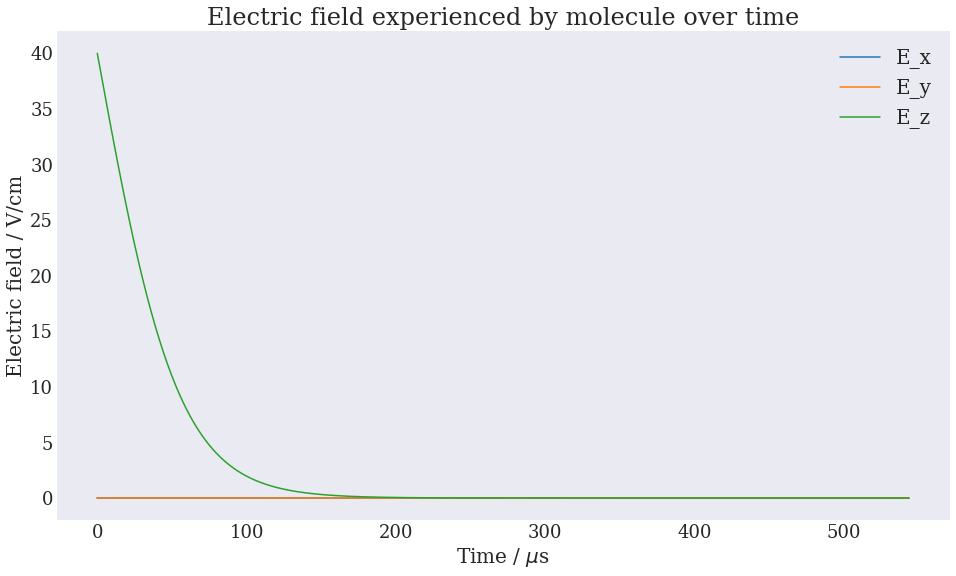

In [99]:
trajectory = Trajectory(Rini = np.array((0,0,0)), Vini = np.array((0,0,184.)), zfin = 1e-1)

V1 = 40
z1 = 0
decayl = 1e-2
E_R = lambda R: E_field_tanh(R, z0 = z1, V = V1, l = decayl  )
electric_field = ElectricField(E_R)

# Plot the electric field as a check:
electric_field.plot(trajectory)

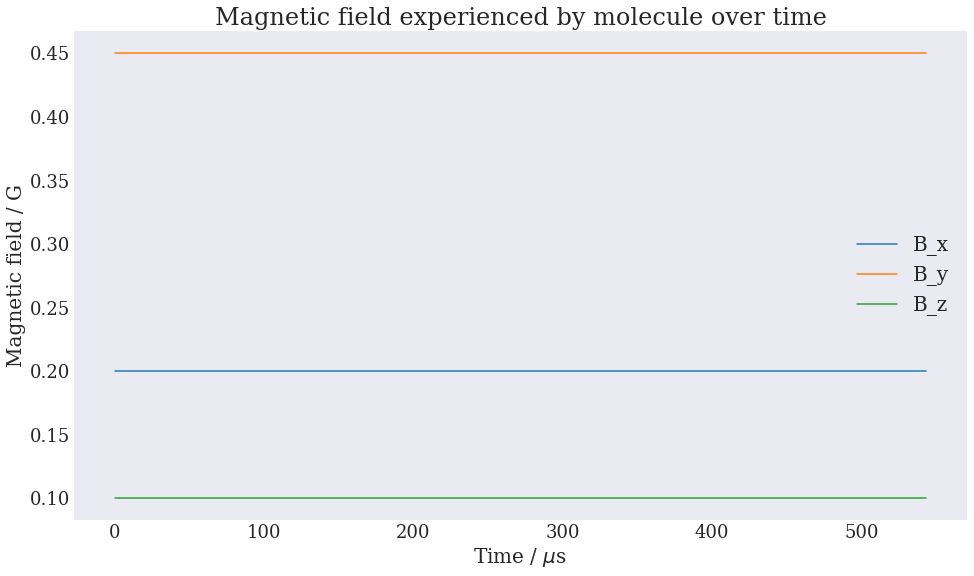

In [100]:
#B = np.array((0,0,1e-3))
B = np.array((0.2,0.45,0.1))
#B = np.array((0,0,1))
magnetic_field = MagneticField(lambda R: np.repeat(B.reshape(3,1),R.shape[1], axis = 1))

magnetic_field.plot(trajectory)

In [101]:
#Define some useful approximate states

J1_up = (1*UncoupledBasisState(J = 1, mJ = 1, I1 = 1/2, m1 = 1/2, I2 = 1/2, m2 = 1/2, P = -1, Omega = 0, electronic_state='X'))

J1_down = (1*UncoupledBasisState(J = 1, mJ = 1, I1 = 1/2, m1 = -1/2, I2 = 1/2, m2 = 1/2, P = -1, Omega = 0, electronic_state='X'))

initial_states_approx = [J1_up, J1_down]

In [102]:
simulator = Simulator(trajectory, electric_field, magnetic_field, initial_states_approx, hamiltonian)
result = simulator.run()

100%|████████████████████████████████████████████████████████████████████████████| 9999/9999 [00:06<00:00, 1437.25it/s]


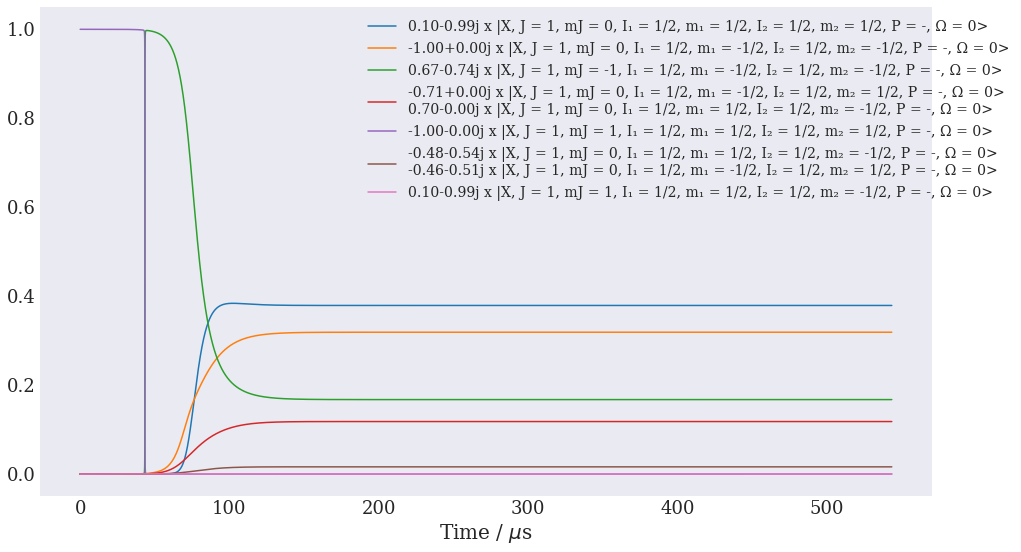

In [103]:
initial_state = result.initial_states[0]
large_prob_states = result.find_large_prob_states(initial_state, N=7)
fig, ax = plt.subplots()
result.plot_state_probabilities(large_prob_states, initial_state, ax = ax, tolerance = 0.5)
ax.legend(fontsize = 14, bbox_to_anchor = (1.1,1))

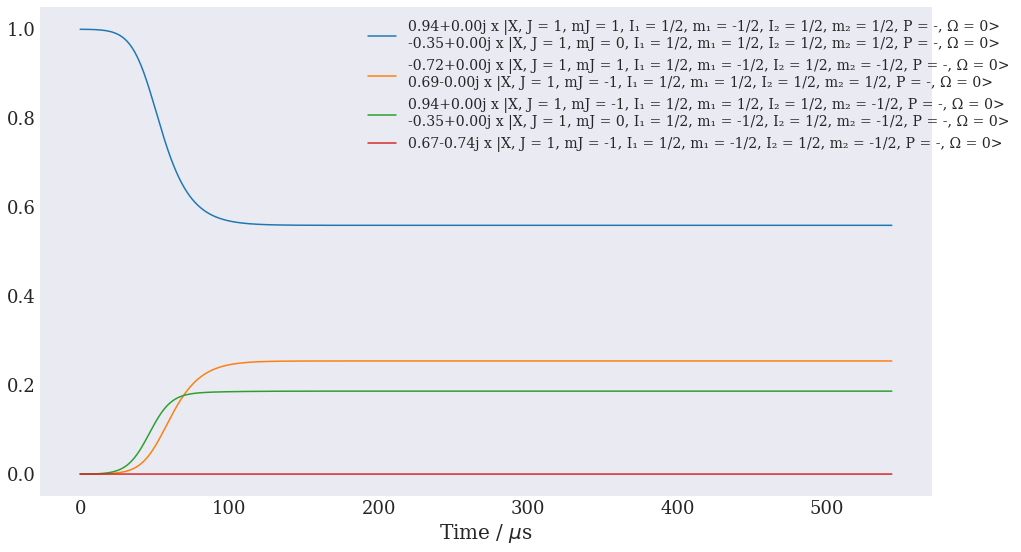

In [104]:
initial_state = result.initial_states[1]
large_prob_states = result.find_large_prob_states(initial_state, N=4)
fig, ax = plt.subplots()
result.plot_state_probabilities(large_prob_states, initial_state, ax = ax, tolerance = 0.2)
ax.legend(fontsize = 14, bbox_to_anchor = (1.1,1))

In [105]:
QN = result.hamiltonian.QN

# Starting in singlet
final_state_vec_J1_up = result.psis[-1,0,:]
final_state_J1_up = (vector_to_state(final_state_vec_J1_up, QN).remove_small_components().transform_to_coupled()
                       .order_by_amp())
print("|J = 1, mJ = 1, m1 = 1/2, m2 = 1/2 > ->")
final_state_J1_up.make_real().print_state()


final_state_vec_J1_down = result.psis[-1,1,:]
final_state_J1_down = (vector_to_state(final_state_vec_J1_down, QN).remove_small_components().transform_to_coupled()
                         .order_by_amp())
print("\n|J = 1, mJ = 1, m1 = -1/2, m2 = 1/2 >  ->")
final_state_J1_down.make_real().print_state()



|J = 1, mJ = 1, m1 = 1/2, m2 = 1/2 > ->
+0.7426+0.0000j x |X, J = 1, F₁ = 3/2, F = 2, mF = -2, I₁ = 1/2, I₂ = 1/2, P = -, Ω = 0>
-0.2562-0.5508j x |X, J = 1, F₁ = 3/2, F = 2, mF = -1, I₁ = 1/2, I₂ = 1/2, P = -, Ω = 0>
-0.1669+0.2122j x |X, J = 1, F₁ = 3/2, F = 2, mF = 0, I₁ = 1/2, I₂ = 1/2, P = -, Ω = 0>

|J = 1, mJ = 1, m1 = -1/2, m2 = 1/2 >  ->
-0.9328+0.0000j x |X, J = 1, F₁ = 1/2, F = 1, mF = -1, I₁ = 1/2, I₂ = 1/2, P = -, Ω = 0>
+0.1429+0.3019j x |X, J = 1, F₁ = 1/2, F = 1, mF = 0, I₁ = 1/2, I₂ = 1/2, P = -, Ω = 0>
